# First-look calibrated spectra
Quick and dirty visualizer, orignally based on Lauren's code.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

This notebook is routinely tested on both Python 2 and Python 3 kernels. Below is collected all of the v2 versus v3 stuff. A scheme from [this link](http://sweetme.at/2013/10/21/how-to-detect-python-2-vs-3-in-your-python-script/) that imports `urllib2` properly depending on the Python version; indeed, [the urllib docs](https://docs.python.org/2/library/urllib.html) describe this issue, along with the absence of `seek`, which haunts us later in this notebook. Also here is a byte-versus-string manner of finding header entries that we use later in this notebook.

In [2]:
import sys
if (sys.version_info > (3, 0)):
    import urllib.request as urllib2
    elev, date, mjd_str = b'ELEV', b'DATE', b'MJD';
else:
    import urllib2
    elev, date, mjd_str = 'ELEV', 'DATE', 'MJD';
# printf like C! https://www.safaribooksonline.com/library/view/python-cookbook-2nd/0596007973/ch04s21.html
def printf(format, *args):
    sys.stdout.write(format % args)

## Read the data from the web
For the given URLs of the calibrator and the maser target, the text files from the web are stored in memory with local "file" handles that don't quite behave as file handles (e.g., no `seek`). Either the "bumble bee" (i.e., "cyb") data or the "butterfly" (i.e., "spect.A") files will work, if paired.

In [3]:
cal_URL = 'http://www.gb.nrao.edu/20m/peak/3C353-028/Skynet_58181_3C353-028_31966_32732.spect.cyb.txt';
cal_response = urllib2.urlopen(cal_URL);

target_URL = 'http://www.gb.nrao.edu/20m/peak/W49-028/Skynet_58181_W49-028_31968_32734.spect.cyb.txt';
target_response = urllib2.urlopen(target_URL);

The web strings are loaded like text files. After skipping the header rows, the remaining columns of numbers are loaded into numpy arrays. The preceding outputs can only be called once lest the buffer read get stuck at the end, it seems. So, below is a single call to make a six-column array which is then sliced into the two IFs. Furthremore, these different arrays could easily be a single array with numerous columns, but are separate here for transparency of processing.

In [4]:
cal = np.loadtxt(cal_response, skiprows = 45, usecols = (0,1,2,3,4,5));
cal_IF1 = cal[:,0:3]; # 'slicing' starts with index 0 and ends with index 3-1 apparently
cal_IF2 = cal[:,3:]; # end limit blank means all the way to the end (not end-1) apparently
target = np.loadtxt(target_response, skiprows = 45, usecols = (0,1,2,3,4,5));
target_IF1 = target[:,0:3];
target_IF2 = target[:,3:];

Plot up a quick look at the different IFs and polarizations.

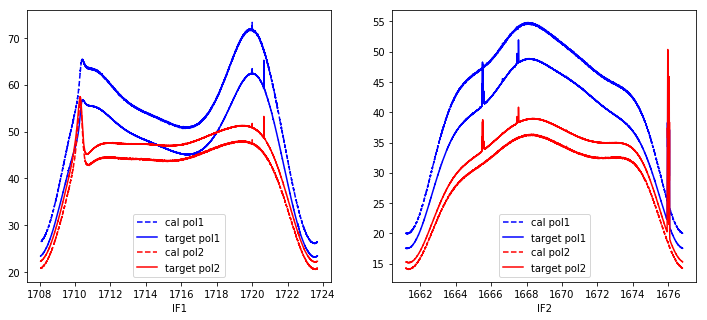

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cal_IF1[:,0], cal_IF1[:,1], 'b--', label="cal pol1")
plt.plot(target_IF1[:,0], target_IF1[:,1], 'b-', label='target pol1')
plt.plot(cal_IF1[:,0], cal_IF1[:,2], 'r--', label='cal pol2')
plt.plot(target_IF1[:,0], target_IF1[:,2], 'r-', label='target pol2')
plt.xlabel('IF1');
plt.legend();
plt.subplot(1,2,2)
plt.plot(cal_IF2[:,0], cal_IF2[:,1], 'b--', label='cal pol1')
plt.plot(target_IF2[:,0], target_IF2[:,1], 'b-', label='target pol1')
plt.plot(cal_IF2[:,0], cal_IF2[:,2], 'r--', label='cal pol2')
plt.plot(target_IF2[:,0], target_IF2[:,2], 'r-', label='target pol2')
plt.xlabel('IF2');
plt.legend();
plt.show() 

## Verify sane statistics with a peek at the cal noise
Without calibrating the bandpass, attempt a polynomial fit to a portion of the calibrator spectrum in order to flatten the band and retrieve some instructive stats. Thes inputs the limits of the fit as channel numbers `chmin` and `chmax`.

In [6]:
# number of channels
nchan = len( cal_IF2[:,0] );
nchan

8190

Pick a portion of the band to fit by specifying the bounding channel numbers.

In [7]:
chmin, chmax = 2100, 2400;

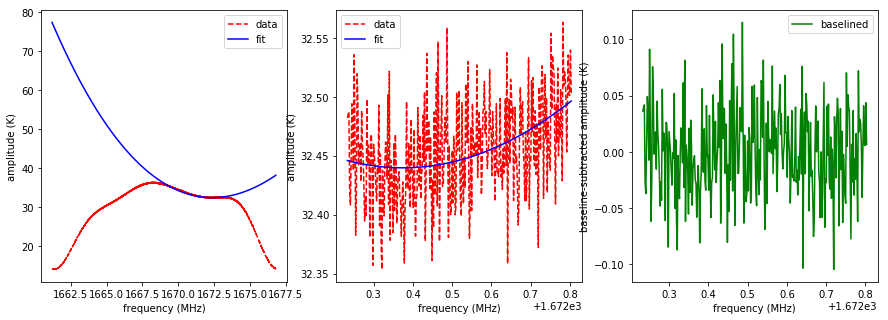

In [8]:
# these commented lines are for a ninth-order polynomial
#def baseline(x, a9,a8,a7,a6,a5,a4,a3,a2,a1,a0):
#    return a9*x*x*x*x*x*x*x*x*x+a8*x*x*x*x*x*x*x*x+a7*x*x*x*x*x*x*x+a6*x*x*x*x*x*x+a5*x*x*x*x*x+a4*x*x*x*x+a3*x*x*x+a2*x*x+a1*x+a0
#popt, pcov = curve_fit(baseline, cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2], bounds=([-2,-2,-10,-10,-10,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf],[2,2,10,10,10,np.inf,np.inf,np.inf,np.inf,np.inf]));

def baseline(x, a4,a3,a2,a1,a0):
    return a4*x*x*x*x+a3*x*x*x+a2*x*x+a1*x+a0

popt, pcov = curve_fit(baseline, cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2]);

plt.figure(figsize=(15,5));
plt.subplot(1,3,1);
plt.plot(cal_IF2[:,0], cal_IF2[:,2], 'r--', label='data')
plt.plot(cal_IF2[:,0], baseline(cal_IF2[:,0], *popt), 'b-', label='fit')
plt.xlabel('frequency (MHz)')
plt.ylabel('amplitude (K)')
plt.legend()
plt.subplot(1,3,2);
plt.plot(cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2], 'r--', label='data')
plt.plot(cal_IF2[chmin:chmax,0], baseline(cal_IF2[chmin:chmax,0], *popt), 'b-', label='fit')
plt.xlabel('frequency (MHz)')
plt.ylabel('amplitude (K)')
plt.legend()
plt.subplot(1,3,3);
plt.plot(cal_IF2[chmin:chmax,0], cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt), 'g-', label='baselined')
plt.xlabel('frequency (MHz)')
plt.ylabel('baseline-subtracted amplitude (K)')
plt.legend()
plt.show()

The root&ndash;mean&ndash;square of the flattened spectrum is given below. Although it depends on the particular observational setup, for typical choices of observation time and channel width the value should be within a factor of a few of 0.05&nbsp;K. See Equation 3E5 in [the ASTR 534 textbook](http://www.cv.nrao.edu/course/astr534/Radiometers.html).

$$\sigma = \frac{2T_\text{sys}}{\sqrt{\Delta\nu_\text{chan}\,t_\text{obs}}}\ .$$

In [9]:
rms = np.sqrt( np.mean( (cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt))
                       *(cal_IF2[chmin:chmax,2]-baseline(cal_IF2[chmin:chmax,0], *popt)) ) );
rms

0.038535360471205475

## Bandpass and gain correction
Independent of the peek at the statistics, we may assemble bandpass-calibrated spectra using the following procedure.
1. Determine the mean of the calibrator spectrum using the inner 80% or so of the band (as set using `edges`).
2. Compute a normalized bandpass spectrum (table) from the calibrator.
3. Determine the telescope gain using flux from [Ott et al.](http://adsabs.harvard.edu/abs/1994A&A...284..331O), [Scaife &amp; Heald](http://adsabs.harvard.edu/abs/2012arXiv1203.0977S), or else [Kellerman et al.](http://adsabs.harvard.edu/abs/1969ApJ...157....1K) indices with [VLA manual](http://www.vla.nrao.edu/astro/calib/manual/csource.html) fluxes. (elevation correction forthcoming)
4. Fold the gain factor into the bandpass table for subsequent one-stop shopping.
5. Divide the maser spectrum by the bandpass-and-gain correction.

In [10]:
#do the URL read again to get a fresh file object---perhaps there is a rewind or something?
cal_response = urllib2.urlopen(cal_URL);
target_response = urllib2.urlopen(target_URL);
#cal_response.seek(0);
#target_response.seek(0);
for line in cal_response:
    if (elev in line) or (date in line):
        print(line);
for line in target_response:
    if (elev in line) or (date in line):
        print(line);
    if ( mjd_str in line):
        mjd = line;

#     DATE_OBS=2018-03-04T10:19:00.870

#    ELEV(deg)=44.957

#     DATE_OBS=2018-03-04T11:41:10.750

#    ELEV(deg)=49.987



Hopefully the elevations displayed above for the calibrator and maser target are comparable. The calibration below does not yet consider elevation correction. (At L-band, this should be alright in terms of absorption, but the standing waves seem to differ by elevation.)

### Steps 1 and 2
Begin by setting the edges of the portion of the band that will be averaged. Basically, if RFI is present, exclude it. The values in `edges` are percentages. Because the frequency axis is in decreasing order, the values get flipped after entry.

In [11]:
edges = np.array([ 0.10, 0.90 ]);
edges[0], edges[1] = 1.0-edges[1], 1.0-edges[0];

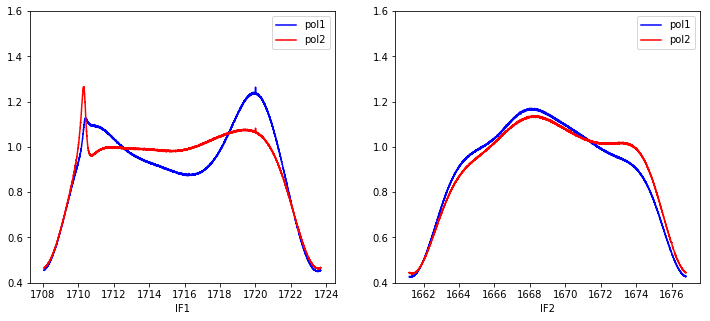

In [12]:
CH0 = np.array([ [ np.mean(cal_IF1[int(edges[0]*nchan):int(edges[1]*nchan),1]), np.mean(cal_IF1[int(edges[0]*nchan):int(edges[1]*nchan),2]) ],[ np.mean(cal_IF2[int(edges[0]*nchan):int(edges[1]*nchan),1]), np.mean(cal_IF2[int(0.10*nchan):int(0.90*nchan),2])] ]);
bpass_IF1 = np.transpose( np.array([ [ cal_IF1[:,0] , np.divide(cal_IF1[:,1],CH0[0,0]) ,  np.divide(cal_IF1[:,2],CH0[0,1]) ] ]) );
bpass_IF2 = np.transpose( np.array([ [ cal_IF2[:,0] , np.divide(cal_IF2[:,1],CH0[1,0]) ,  np.divide(cal_IF2[:,2],CH0[1,1]) ] ]) );
bpass_IF1 = np.squeeze(bpass_IF1,axis=2);
bpass_IF2 = np.squeeze(bpass_IF2,axis=2);
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bpass_IF1[:,0], bpass_IF1[:,1], 'b-', label='pol1')
plt.plot(bpass_IF1[:,0], bpass_IF1[:,2], 'r-', label='pol2')
plt.xlabel('IF1');
plt.ylim([0.4,1.6])
plt.legend();
plt.subplot(1,2,2)
plt.plot(bpass_IF2[:,0], bpass_IF2[:,1], 'b-', label='pol1')
plt.plot(bpass_IF2[:,0], bpass_IF2[:,2], 'r-', label='pol2')
plt.xlabel('IF2');
plt.ylim([0.4,1.6])
plt.legend();
plt.show()

Above are the plots of the bandpass tables. The CH0 values are converted to gains in units of Jy/K using the Ott fluxes below.

In [13]:
CH0

array([[58.02772591, 44.55724523],
       [46.8508076 , 31.97444884]])

The CH0 values above are in Kelvins.

### Steps 3 and 4
 The code in the following cell determines the expected calibrator flux in Jy and adjusts the bandpass factor accordingly.

In [14]:
f1 = target_IF1[int(len(target_IF1)/2.0),0];
f2 = target_IF2[int(len(target_IF2)/2.0),0];
if "3C48" in cal_URL:
    flux = np.array([ 10.0**(2.465-0.004*np.log10(f1)-0.1251*np.log10(f1)*np.log10(f1)), 10.0**(2.465-0.004*np.log10(f2)-0.1251*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C48';
elif "3C123" in cal_URL:
    flux = np.array([ 10.0**(2.525+0.246*np.log10(f1)-0.1638*np.log10(f1)*np.log10(f1)), 10.0**(2.525+0.246*np.log10(f2)-0.1638*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C123';
elif "3C147" in cal_URL:
    flux = np.array([ 10.0**(2.806-0.140*np.log10(f1)-0.1031*np.log10(f1)*np.log10(f1)), 10.0**(2.806-0.140*np.log10(f2)-0.1031*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C147';
elif "3C286" in cal_URL:
    flux = np.array([ 10.0**(0.956+0.584*np.log10(f1)-0.1644*np.log10(f1)*np.log10(f1)), 10.0**(0.956+0.584*np.log10(f2)-0.1644*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C286';
elif "3C295" in cal_URL:
    flux = np.array([ 10.0**(1.490+0.756*np.log10(f1)-0.2545*np.log10(f1)*np.log10(f1)), 10.0**(1.490+0.756*np.log10(f2)-0.2545*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C295';
elif "3C348" in cal_URL:
    flux = np.array([ 10.0**(3.852-0.361*np.log10(f1)-0.1053*np.log10(f1)*np.log10(f1)), 10.0**(3.852-0.361*np.log10(f2)-0.1053*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C348';
elif "3C353" in cal_URL:
    flux = np.array([ 10.0**(3.148-0.157*np.log10(f1)-0.0911*np.log10(f1)*np.log10(f1)), 10.0**(3.148-0.157*np.log10(f2)-0.0911*np.log10(f2)*np.log10(f2))]);
    cal_name = '3C353';
elif "3C380" in cal_URL:
    flux = np.array([ 10.0**(np.log10(75.682)-0.772*np.log10(f1/150.0)+0.039*np.log10(f1/150.0)*np.log10(f1/150.0)), 10.0**(np.log10(75.682)-0.772*np.log10(f2/150.0)+0.039*np.log10(f2/150.0)*np.log10(f2/150.0))]);
    cal_name = '3C380';
elif "3C394" in cal_URL:
    flux = np.array([ 2.8*(1400.0/f1)**0.88, 2.8*(1400.0/f2)**0.88 ]);
    cal_name = '3C394';
elif "3C418" in cal_URL:
    flux = np.array([ 5.8*(1400.0/f1)**0.27, 5.8*(1400.0/f2)**0.27 ]);
    cal_name = '3C418';
else:
    flux = np.array([ 1.0, 1.0 ]);
    cal_name = 'failure';
# determine gain from flux
gain = np.array([ flux/CH0[:,0], flux/CH0[:,1] ]);
bpass_IF1[:,1], bpass_IF1[:,2] = bpass_IF1[:,1]/gain[0,0], bpass_IF1[:,2]/gain[1,0];
bpass_IF2[:,1], bpass_IF2[:,2] = bpass_IF2[:,1]/gain[0,1], bpass_IF2[:,2]/gain[1,1];

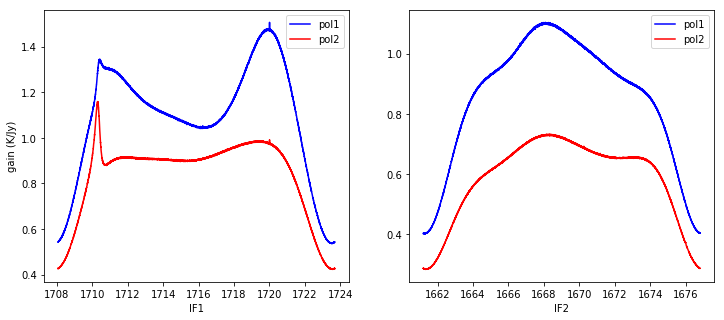

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bpass_IF1[:,0], bpass_IF1[:,1], 'b-', label='pol1')
plt.plot(bpass_IF1[:,0], bpass_IF1[:,2], 'r-', label='pol2')
plt.xlabel('IF1');
plt.ylabel('gain (K/Jy)');
plt.legend();
plt.subplot(1,2,2)
plt.plot(bpass_IF2[:,0], bpass_IF2[:,1], 'b-', label='pol1')
plt.plot(bpass_IF2[:,0], bpass_IF2[:,2], 'r-', label='pol2')
plt.xlabel('IF2');
plt.legend();
plt.show()

### Step 5

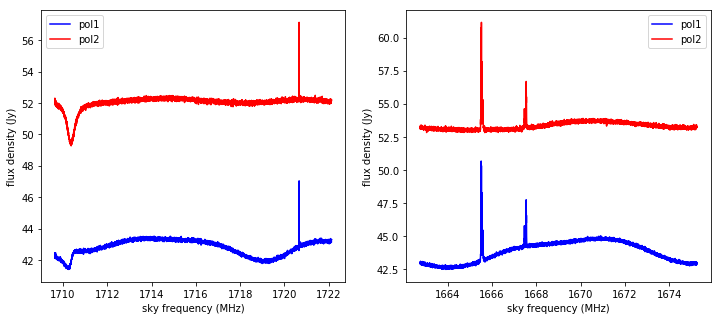

In [16]:
bpassed_IF1 = np.divide( target_IF1,bpass_IF1 );
bpassed_IF2 = np.divide( target_IF2,bpass_IF2 );
#bpassed_IF1 = np.transpose( np.array( [ np.array([target_IF1[:,0]]) , np.divide(target_IF1[:,1],np.transpose(bpass_IF1[:,1])) ,  np.divide(target_IF1[:,2],np.transpose(bpass_IF1[:,2])) ] ) );
#bpassed_IF2 = np.transpose( np.array( [ np.array([target_IF2[:,0]]) , np.divide(target_IF2[:,1],np.transpose(bpass_IF2[:,1])) ,  np.divide(target_IF2[:,2],np.transpose(bpass_IF2[:,2])) ] ) );
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(target_IF1[int(edges[0]*nchan):int(edges[1]*nchan),0], bpassed_IF1[int(edges[0]*nchan):int(edges[1]*nchan),1], 'b-', label='pol1')
plt.plot(target_IF1[int(edges[0]*nchan):int(edges[1]*nchan),0], bpassed_IF1[int(edges[0]*nchan):int(edges[1]*nchan),2], 'r-', label='pol2')
plt.legend();
plt.xlabel('sky frequency (MHz)')
plt.ylabel('flux density (Jy)')
plt.subplot(1,2,2)
plt.plot(target_IF2[int(edges[0]*nchan):int(edges[1]*nchan),0], bpassed_IF2[int(edges[0]*nchan):int(edges[1]*nchan),1], 'b-', label='pol1')
plt.plot(target_IF2[int(edges[0]*nchan):int(edges[1]*nchan),0], bpassed_IF2[int(edges[0]*nchan):int(edges[1]*nchan),2], 'r-', label='pol2')
plt.legend();
plt.xlabel('sky frequency (MHz)')
plt.ylabel('flux density (Jy)')
plt.show()

Below are some zoomed-in views of a few maser lines in the calibrated data. The plots all have a common amplitude scale, set using `smin` and `smax`.

In [17]:
smin, smax = 42.0, 62.0;

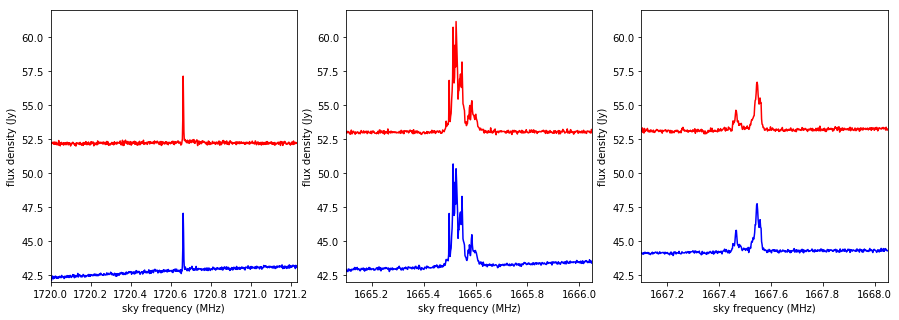

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(target_IF1[:,0], bpassed_IF1[:,1], 'b-')
plt.plot(target_IF1[:,0], bpassed_IF1[:,2], 'r-')
plt.xlabel('sky frequency (MHz)');
plt.ylabel('flux density (Jy)');
plt.xlim( [1720.00, 1721.230] );
plt.ylim( [smin, smax] );
plt.subplot(1,3,2)
plt.plot(target_IF2[:,0], bpassed_IF2[:,1], 'b-')
plt.plot(target_IF2[:,0], bpassed_IF2[:,2], 'r-')
plt.xlabel('sky frequency (MHz)');
plt.ylabel('flux density (Jy)');
plt.xlim( [1665.10, 1666.050] );
plt.ylim( [smin, smax] );
plt.subplot(1,3,3)
plt.plot(target_IF2[:,0], bpassed_IF2[:,1], 'b-')
plt.plot(target_IF2[:,0], bpassed_IF2[:,2], 'r-')
plt.xlabel('sky frequency (MHz)');
plt.ylabel('flux density (Jy)');
plt.xlim( [1667.10, 1668.050] );
plt.ylim( [smin, smax] );
plt.show()

The preceding plots are for each polarization individually. The plot below is a single, averaged "Stokes I" spectrum.

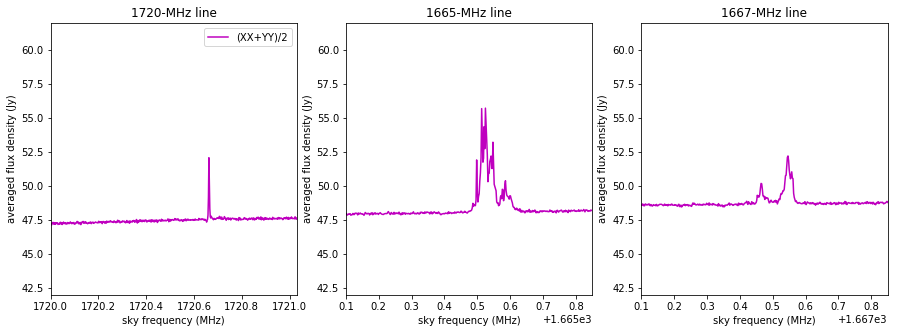

In [19]:
#avg_IF1, avg_IF2 = bpassed_IF1[:,1], bpassed_IF2[:,1];
avg_IF1, avg_IF2 = (bpassed_IF1[:,1]+bpassed_IF1[:,2])/2.0, (bpassed_IF2[:,1]+bpassed_IF2[:,2])/2.0;
#%matplotlib notebook
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(target_IF1[:,0], avg_IF1, 'm-', label='(XX+YY)/2')
plt.title('1720-MHz line');
plt.xlabel('sky frequency (MHz)');
plt.ylabel('averaged flux density (Jy)');
plt.legend();
plt.xlim( [1720.00, 1721.030] );
plt.ylim( [smin, smax] );
plt.subplot(1,3,2)
plt.plot(target_IF2[:,0], avg_IF2, 'm-')
plt.title('1665-MHz line');
plt.xlabel('sky frequency (MHz)');
plt.ylabel('averaged flux density (Jy)');
plt.xlim( [1665.10, 1665.850] );
plt.ylim( [smin, smax] );
plt.subplot(1,3,3)
plt.plot(target_IF2[:,0], avg_IF2, 'm-')
plt.title('1667-MHz line');
plt.xlabel('sky frequency (MHz)');
plt.ylabel('averaged flux density (Jy)');
plt.xlim( [1667.10, 1667.850] );
plt.ylim( [smin, smax] );
plt.show()

If no plot appears above, click in its cell code and press `Ctrl+Enter`.

Set the frequency boundaries of the region for the line fit. Again, since the frequency axis runs backward, so too do the entries. The plots above can be used to eye-ball entires for `gmax`, `gmin`, and `b2`.

In [20]:
gmax,gmin = 1500, 1800;
target_IF1[gmax,0], target_IF1[gmin,0]

(1720.82266, 1720.25046)

In [21]:
b4,b3,b2,b1,b0 = 0.25, 0.01, 1720.6550, +4.754e-1, -834.0;

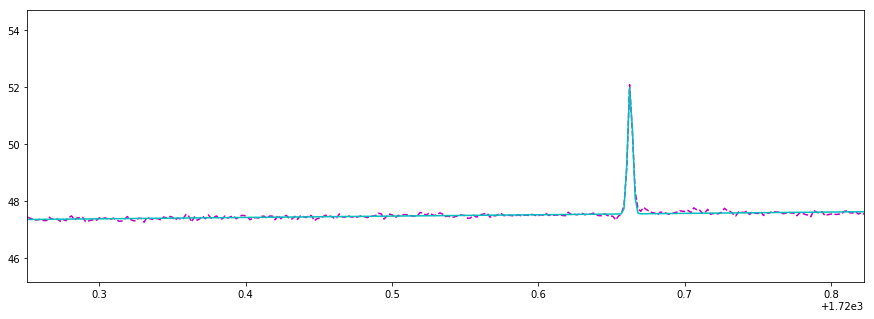

In [22]:
def gauss(x, b4,b3,b2,b1,b0):
    return b4*np.exp(-0.5*(x-b2)*(x-b2)/b3/b3) + b1*x + b0

popt, pcov = curve_fit(gauss, target_IF1[gmax:gmin,0], avg_IF1[gmax:gmin], p0=np.array([b4,b3,b2,b1,b0]), bounds=([0.01,1e-4,target_IF1[gmin,0],-10.0,-8000.0],[900.0,10.0,target_IF1[gmax,0],+10.0,+8000.0]));
perr = np.sqrt(np.diag(pcov));
#popt = np.array([b4,b3,b2,b1,b0]);

%matplotlib inline
plt.figure(figsize=(15,5));
plt.plot(target_IF1[:,0], avg_IF1, 'm--', label='data')
plt.plot(target_IF1[:,0], gauss(target_IF1[:,0], *popt), 'c-', label='fit')
plt.xlim([target_IF1[gmin,0], target_IF1[gmax,0]]);
plt.ylim([(popt[3]*popt[2]+popt[4])*0.95, (popt[3]*popt[2]+popt[4]+popt[0])*1.05]);
plt.show()

In [23]:
print(target_URL);
print(mjd);
printf("Based on %s, the maser is %.3f+/-%.3f Jy above a %.2f-Jy continuum.", cal_name, popt[0], perr[0], popt[3]*popt[2]+popt[4]);

http://www.gb.nrao.edu/20m/peak/W49-028/Skynet_58181_W49-028_31968_32734.spect.cyb.txt
#          MJD=58181.5131

Based on 3C353, the maser is 4.535+/-0.061 Jy above a 47.56-Jy continuum.

For sanity-checks on the continuum levels from the maser sources, consider the following references:
* W49: a few tens of Jy. ([here](http://adsabs.harvard.edu/abs/1967ApJ...150..807M) and [here](http://adsabs.harvard.edu/abs/1966PASJ...18..209A))
* W3: a few tens of Jy: ([here](http://adsabs.harvard.edu/abs/1980MNRAS.193..495C))
* [this reference](http://adsabs.harvard.edu/abs/1972AJ.....77..405B) doesn't list Westerhout names, but may be useful

To do list:
* elevation correction for calibrator amplitude
* automated search for frequency limits of line fit
* automated computation of sigma from Tsys, etc.
* automated setting of `smin`, `smax` amplitude limits in final plots.
* rework IF arrays into a single, monolithic data structure
* improve work-around for lack of `seek` in URL handles
* `dopset` (or dopset-like) computation of LSR velocities